# 音声認識・対話技術講習会　音源分離の基礎と最新動向　演習資料
- 本演習では，[pyroomacoustics](https://github.com/LCAV/pyroomacoustics)を用いたブラインド音源分離（AuxIVA，ILRMA）を行います．
- 本演習のコードは，pyroomacousticsのデモ用notebookを基に作成されています．

Created by Tomohiko Nakamura and Hiroshi Saruwatari

## 環境設定

必要なライブラリをインストール

In [ ]:
!pip install pyroomacoustics==0.7.3

ライブラリをインポート

In [ ]:
import numpy
import librosa
import soundfile
import IPython.display
import pyroomacoustics
import matplotlib.pyplot as plt
import librosa.display

音サンプルファイルをダウンロード

In [ ]:
!wget --quiet -O sample_jvs001.wav "https://drive.google.com/uc?export=download&id=142aj-qFJOhoteWKqgRzvNoq02JbZIsaG"
!wget --quiet -O sample_jvs002.wav "https://drive.google.com/uc?export=download&id=1idCghceyP9HldFnBKKx9_2ENqXWnr7IP"
!wget --quiet -O sample_jvs003.wav "https://drive.google.com/uc?export=download&id=1plvIsG5Y0l-lYYAMIBH8YHRkDr_prwLM"
!wget --quiet -O sample_pjs001.wav "https://drive.google.com/uc?export=download&id=1rvkjFYViRer120UiAa2rtveDzbhtNEAN"
!wget --quiet -O sample_trijek001_en.wav "https://drive.google.com/uc?export=download&id=1JdUU2CTTxHZHnftoUh12T7Ozggc_SQ-B"

## 音ファイルの読み込み

音ファイル読み込み用関数を定義

In [ ]:
def load_audio_file(filename, target_sample_rate, max_duration=20.0):
  waveform, org_sample_rate = soundfile.read(filename, stop=int(soundfile.info(filename).samplerate*max_duration), always_2d=True)
  waveform = waveform.mean(axis=1)
  waveform = librosa.resample(y=waveform.T, orig_sr=org_sample_rate, target_sr=target_sample_rate).T
  return waveform

利用可能な音ファイル

In [ ]:
!ls *.wav

sample_jvs001.wav  sample_jvs003.wav  sample_trijek001_en.wav
sample_jvs002.wav  sample_pjs001.wav


対象となる音ファイルを指定し，読み込み

In [ ]:
sample_rate = 16000

waveforms = [
    load_audio_file(librosa.example("libri1"), sample_rate).astype('f'),
    load_audio_file(librosa.example("libri2"), sample_rate).astype('f'),
]

# JVSのサンプル音で実行する場合はこちら
# waveforms = [
#     load_audio_file("sample_jvs002.wav", sample_rate).astype('f'),
#     load_audio_file("sample_jvs001.wav", sample_rate).astype('f'),
# ]

## シミュレーションによる混合音作成

部屋，音源，マイクの位置を設定

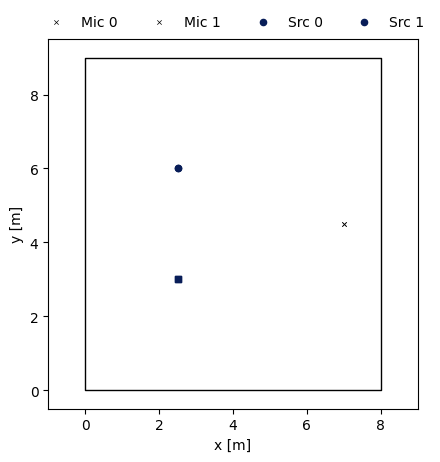

In [ ]:
# 部屋の大きさ（x軸，y軸）．原点は(0,0)．
room_dim = [8, 9]

# 音源位置
src_locations = [
    [2.5, 6.0], # Src 1
    [2.5, 3.0], # Src 2
]
# 音源再生時の時間遅れ [s]
delays = [1.0, 0.0]

# マイク位置
mic_locations = numpy.c_[
    [7, 4.495], # Mic 1
    [7, 4.505], # Mic 2
]

# 部屋を作成
room = pyroomacoustics.ShoeBox(room_dim, fs=sample_rate, max_order=15, absorption=0.35, sigma2_awgn=1e-8)

# 部屋への音源の登録と，音源再生時の時間遅れの付与
for sig, d, loc in zip(waveforms, delays, src_locations):
    room.add_source(loc, signal=sig, delay=d)

# 部屋へのマイクアレイの登録
room.add_microphone_array(pyroomacoustics.MicrophoneArray(mic_locations, room.fs))

# 部屋，音源，マイクの図示
fig, ax = room.plot()
ax.set_xlabel("x [m]")
ax.set_ylabel("y [m]")
ax.set_box_aspect(1)
ax.set_xlim([-0.5, 0.5+room_dim[0]])
ax.set_ylim([-0.5, 0.5+room_dim[1]])
ax.legend([f"Mic {m}" for m in range(mic_locations.shape[1])]+[f"Src {n}" for n in range(len(src_locations))], ncol=4, loc="upper left", bbox_to_anchor=(-0.05, 1.1), fancybox=False, frameon=False)
plt.show()

正解音源と混合音の作成

In [ ]:
# 正解音源の作成（各マイクで各音源のみを再生したときの音響信号）
separate_recordings = room.simulate(return_premix=True) # 音源数 x マイク数 x 時間

# 混合音の作成
observed_signals = numpy.sum(separate_recordings, axis=0) # マイク数 x 時間

for m in range(observed_signals.shape[0]):
  print(f"Mixture signal: Channel {m}")
  IPython.display.display(IPython.display.Audio(observed_signals[m,:], rate=room.fs))

Mixture signal: Channel 0


Mixture signal: Channel 1


# AuxIVAとILRMAの実行

観測音に対する短時間Fourier変換（STFT）の実行

In [ ]:
# STFTのパラメータ
window_length = 2048
hopsize = window_length // 4
analysis_window = pyroomacoustics.windows.hann(window_length)
synthesis_window = pyroomacoustics.transform.stft.compute_synthesis_window(analysis_window, hopsize)

# 観測STFT
X = pyroomacoustics.transform.stft.analysis(observed_signals.T, window_length, hopsize, win=analysis_window)

In [ ]:
# スペクトログラム表示用クラス
class SpectrogramVisualizer:
  def __init__(self, sample_rate, window_length, hopsize, fig_size=(10,3)):
    self.sample_rate = sample_rate
    self.window_length = window_length
    self.hopsize = hopsize
    self.reset()
    self.fig_size = fig_size

  def reset(self):
    self.iteration_counter = 0

  def __call__(self, Y, title="Separated", draw_iteration_number=True):
    fig = plt.figure()
    fig.set_size_inches(*self.fig_size)
    for n in range(Y.shape[2]):
      plt.subplot(1, Y.shape[2], n+1)
      librosa.display.specshow(
          librosa.amplitude_to_db(numpy.abs(Y[:,:,n].T), ref=numpy.max), y_axis="linear", x_axis="time",
          sr=self.sample_rate, win_length=self.window_length, hop_length=self.hopsize
        )
      plt.xlabel("Time [s]", fontsize=13)
      if n == 0:
        plt.ylabel("Frequency [Hz]", fontsize=13)
      else:
        plt.ylabel("")
      plt.title(f'{title} {n+1} (Iteration {self.iteration_counter})' if draw_iteration_number else f'{title} {n+1}')
    plt.show(block=False)
    self.iteration_counter += 10

visualizer = SpectrogramVisualizer(room.fs, window_length=window_length, hopsize=hopsize)

AuxIVAの実行と逆STFTの適用

In [ ]:
visualizer.reset()

# AuxIVAを実行
auxiva_Y = pyroomacoustics.bss.auxiva(X, n_iter=50, proj_back=True, callback=visualizer)
visualizer(auxiva_Y)

# iSTFTで分離信号を取得
auxiva_y = pyroomacoustics.transform.stft.synthesis(auxiva_Y, window_length, hopsize, win=synthesis_window)
auxiva_y = auxiva_y[window_length - hopsize:, :].T

Output hidden; open in https://colab.research.google.com to view.

ILRMAの実行

In [ ]:
visualizer.reset()

# ILRMAの実行
ilrma_Y = pyroomacoustics.bss.ilrma(X, n_iter=50, n_components=10, proj_back=True, callback=visualizer)
visualizer(ilrma_Y)

# iSTFTで分離信号を取得
ilrma_y = pyroomacoustics.transform.stft.synthesis(ilrma_Y, window_length, hopsize, win=synthesis_window)
ilrma_y = ilrma_y[window_length - hopsize:, :].T

Output hidden; open in https://colab.research.google.com to view.

正解音，分離音のスペクトログラムを表示

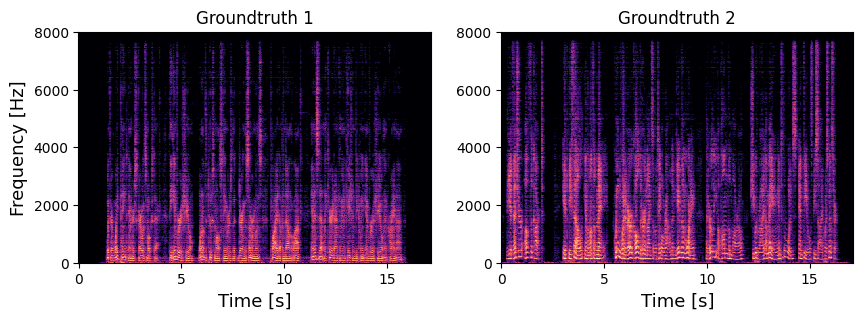

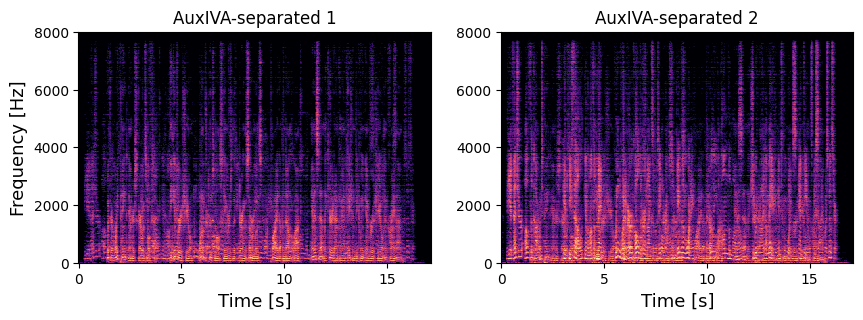

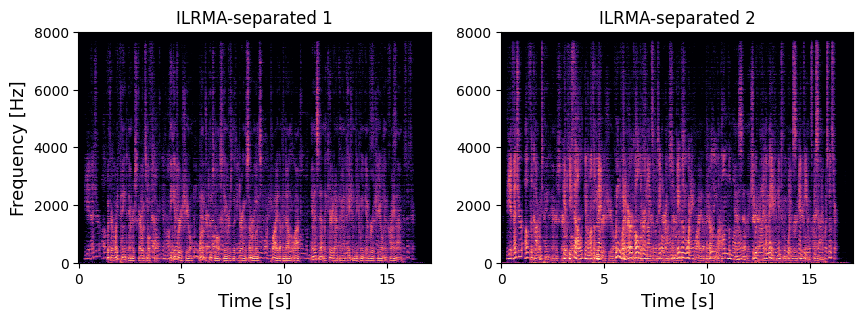

In [ ]:
visualizer(pyroomacoustics.transform.stft.analysis(separate_recordings[:,0,:].T, window_length, hopsize, win=analysis_window), title="Groundtruth", draw_iteration_number=False)
visualizer(auxiva_Y, title="AuxIVA-separated", draw_iteration_number=False)
visualizer(ilrma_Y, title="ILRMA-separated", draw_iteration_number=False)

観測音，分離音，正解音の聴取

In [ ]:
# target_src_indexを1にすると，もう一方の音源を聴けます．
target_src_index = 0

print("Mixture signal (reference mic)")
IPython.display.display(IPython.display.Audio(observed_signals[target_src_index], rate=room.fs))

print("Groundtruth signal")
IPython.display.display(IPython.display.Audio(separate_recordings[target_src_index,0,:], rate=room.fs))

print("Separated signal (AuxIVA)")
IPython.display.display(IPython.display.Audio(auxiva_y[target_src_index,:], rate=room.fs))

print("Separated signal (ILRMA)")
IPython.display.display(IPython.display.Audio(ilrma_y[target_src_index,:], rate=room.fs))


Output hidden; open in https://colab.research.google.com to view.